In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, log_loss
import numpy as np

In [2]:
# Load the dataset
file_path = 'Gaming1.csv'  # Update this path if necessary
data = pd.read_csv(file_path)

# Display the first few rows and summary of the dataset to understand its structure
data.head(), data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Game              650 non-null    object 
 1   ReleaseDate       650 non-null    int64  
 2   Genre             650 non-null    object 
 3   TotalEarnings     650 non-null    float64
 4   OfflineEarnings   650 non-null    float64
 5   PercentOffline    583 non-null    float64
 6   TotalPlayers      650 non-null    int64  
 7   TotalTournaments  650 non-null    int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 40.8+ KB


(                    Game  ReleaseDate     Genre  TotalEarnings  \
 0         Age of Empires         1997  Strategy      510716.46   
 1      Age of Empires II         1999  Strategy     3253232.59   
 2     Age of Empires III         2005  Strategy      115843.65   
 3      Age of Empires IV         2021  Strategy      994675.03   
 4  Age of Empires Online         2011  Strategy        9806.56   
 
    OfflineEarnings  PercentOffline  TotalPlayers  TotalTournaments  
 0        375857.63        0.735942           473               265  
 1       1139384.57        0.350232          1994              1613  
 2         41800.00        0.360831           166               163  
 3        409117.93        0.411308           542               327  
 4           775.00        0.079029            44                50  ,
 None,
        ReleaseDate  TotalEarnings  OfflineEarnings  PercentOffline  \
 count   650.000000   6.500000e+02     6.500000e+02      583.000000   
 mean   2012.576923   2.52

In [3]:
# Define features and target variable
X = data.drop(columns=['Game', 'TotalPlayers'])
y = data['TotalPlayers']

# To convert the problem to a classification problem, we will binarize the target variable
# For simplicity, we'll classify the total number of players into 3 bins: low, medium, high
y_binned = pd.qcut(y, q=3, labels=[0, 1, 2])

In [4]:
# Define preprocessing for numeric columns (impute missing values and scale)
numeric_features = ['ReleaseDate', 'TotalEarnings', 'OfflineEarnings', 'PercentOffline', 'TotalTournaments']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = ['Genre']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.2, random_state=42)

In [6]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [7]:
# Train and evaluate models
results = {}
for model_name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_pred_proba)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Log Loss': loss
    }

In [8]:
# Display the results
results

{'Logistic Regression': {'Accuracy': 0.5923076923076923,
  'F1 Score': 0.5749851618069621,
  'Precision': 0.581307769656186,
  'Log Loss': 0.8183926808726709},
 'Decision Tree': {'Accuracy': 0.8076923076923077,
  'F1 Score': 0.803835559393238,
  'Precision': 0.8059829059829059,
  'Log Loss': 6.931471805599452},
 'K-Nearest Neighbors': {'Accuracy': 0.6,
  'F1 Score': 0.6014755684567006,
  'Precision': 0.604628251079864,
  'Log Loss': 3.7103248990744264}}

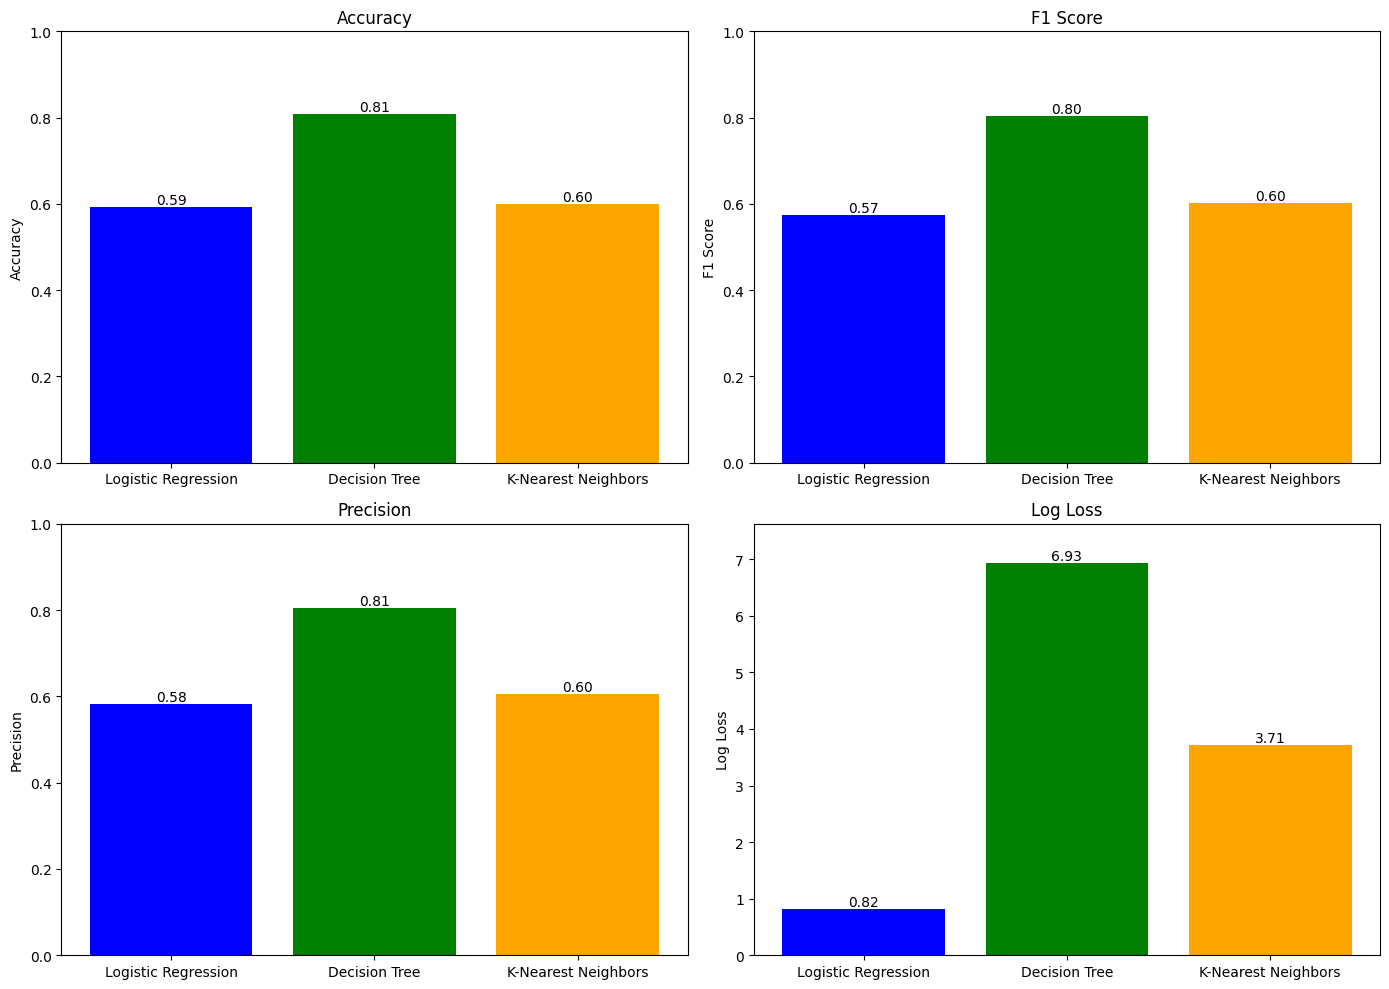

In [9]:
import matplotlib.pyplot as plt

# Function to plot the evaluation metrics
def plot_results(results):
    metrics = ['Accuracy', 'F1 Score', 'Precision', 'Log Loss']
    models = list(results.keys())

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in models]
        ax = axes[i//2, i%2]
        ax.bar(models, values, color=['blue', 'green', 'orange'])
        ax.set_title(metric)
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1 if metric != 'Log Loss' else max(values) * 1.1)
        for index, value in enumerate(values):
            ax.text(index, value, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_results(results)

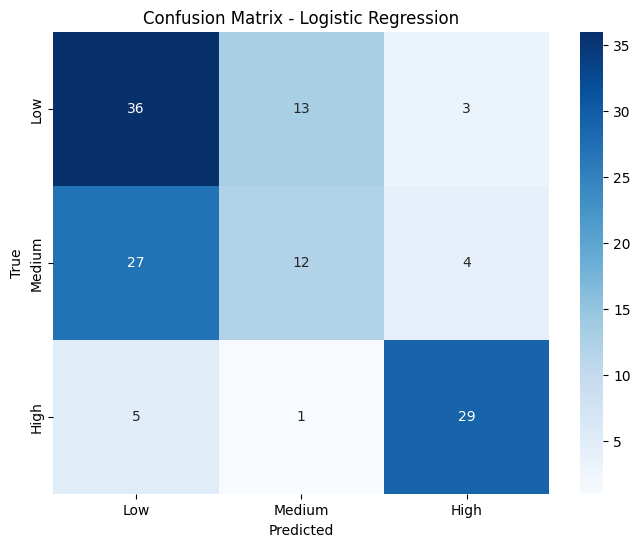

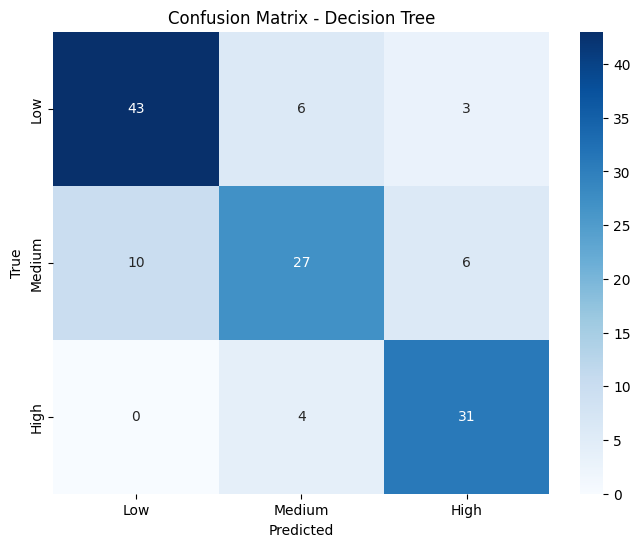

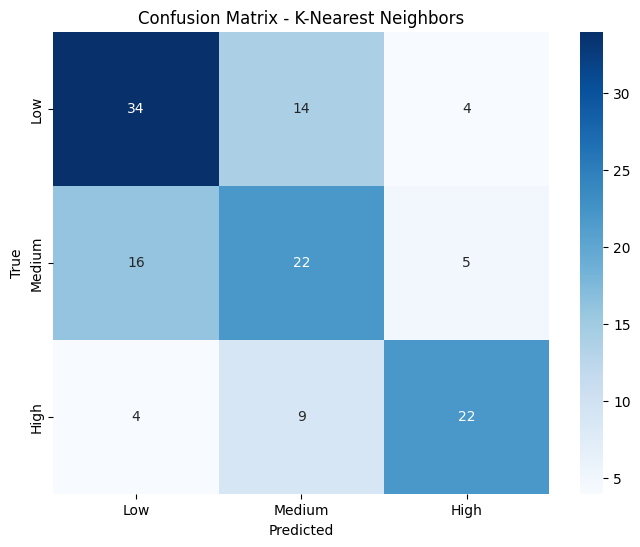

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrices
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrices for each model
for model_name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)

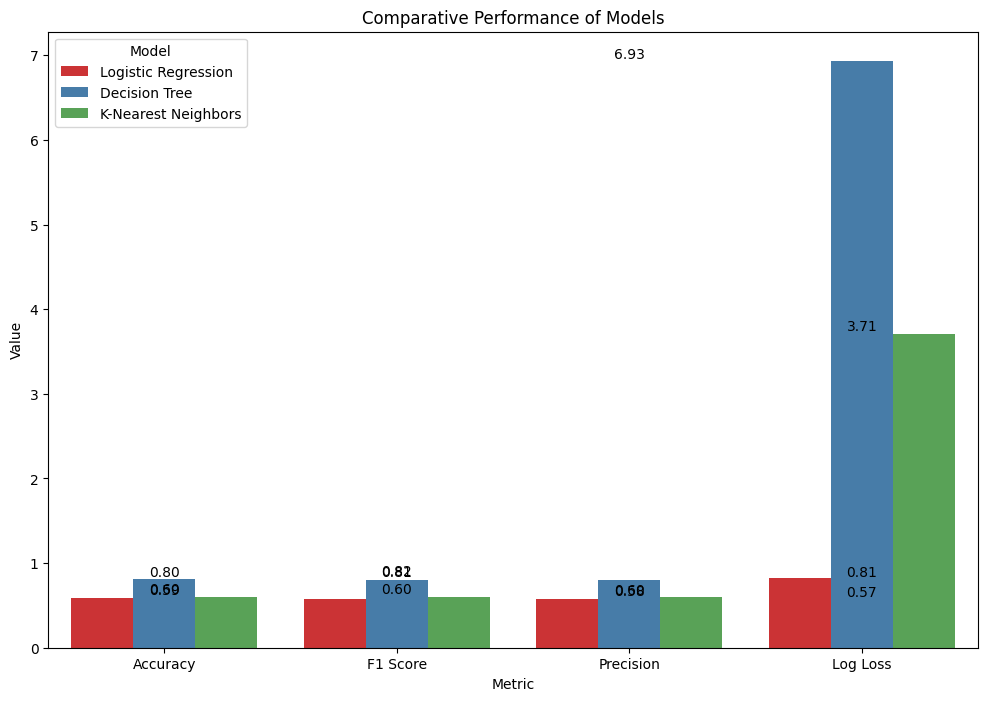

In [11]:
# Function to plot comparative performance
def plot_comparative_performance(results):
    metrics = ['Accuracy', 'F1 Score', 'Precision', 'Log Loss']
    models = list(results.keys())

    data = []
    for metric in metrics:
        for model in models:
            data.append([model, metric, results[model][metric]])

    df = pd.DataFrame(data, columns=['Model', 'Metric', 'Value'])

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Metric', y='Value', hue='Model', data=df, palette='Set1')
    plt.title('Comparative Performance of Models')
    plt.ylim(0, 1 if 'Log Loss' not in df['Metric'].values else None)
    for index, row in df.iterrows():
        plt.text(index % 4, row.Value, f'{row.Value:.2f}', ha='center', va='bottom')
    plt.show()

# Call the function to plot comparative performance
plot_comparative_performance(results)